In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import folium
import pandas as pd
from ipywidgets.widgets import interact
folium.__version__ == '0.5.0'

True

# 1. Europe Map

We first import the topojson

In [12]:
topojson_europe_path = 'topojson/europe.topojson.json'
topojson_europe = json.load(open(topojson_europe_path))

To improve map interaction, we want to add markers one each country, so that we can display the exact data showed on the map. To do so, we have downloaded a csv of all the countries with the position of their respective capital. We check that the countries in the topojson match the countries in the csv, and we rename the countries that mismatch.
Also, we remove the 'United States' row as it cause a shift in the csv, and we do not need it.
We also remove Vatican city because we don't have data for this country, and it hides Italy data on the map.

Link for the csv: http://techslides.com/list-of-countries-and-capitals

In [13]:
# csv for capital locations preprocessing
#http://techslides.com/list-of-countries-and-capitals
countries = pd.read_csv('./europe_data/country-capitals.csv')
countries.index = countries['CountryName']
for i in range(len(topojson_europe['objects']['europe']['geometries'])):
    name = topojson_europe['objects']['europe']['geometries'][i]['properties']['NAME']
    if not name in countries.index:
        print(name)

countries = countries[countries['CapitalLatitude'] != ' D.C.'].rename({'Moldova':'Republic of Moldova',
                                                                      'Macedonia': 'The former Yugoslav Republic of Macedonia'})

The former Yugoslav Republic of Macedonia
Republic of Moldova
Holy See (Vatican City)


Here we define all the functions implemented to output the map we want.

1. opacity_nan function allows to determine if we have data for a specified country. If there's some data, an opacity of 0 is defined for the country, and if there's no data, an opacity of 1. With this opacity, we then attribute a grey layer (in the function put_nan_layer) on every country, that finally appears only on coutries with no data. It allows our map to well show for which country we have unavailable data.

2. get_value_or_NaN returns the value of a field, or an 'Unavailable data' message when the field is empty or doesn't exist. This value will be displayed in markers.

3. get_clean_df returns a clean panda dataframe given the path of the excel file we want to load.

4. put_nan_layer puts the grey layer, calling the opacity_nan_function

5. generate_map creates the map we want for a given excel path and a year. We can specify if we want the markers displayed or not (by default we do not display it). It calls the choroplet built-in function to draw the density map, and then set the NaN layer before adding the markers if asked.

6. generate_growth_map does the same as generate_map but shows the evolution between two years passed as arguments.



In [14]:
def opacity_nan(df, country,year):
    if not country in df[year].dropna().index:
        return 1
    else:
        return 0
    
def get_value_or_NaN(df, country, year):
    if (country in df.index):
        if (pd.notnull(df.loc[country][year])):
            return str(df.loc[country][year]) + '%'
    return 'Unavailable data'

def get_clean_df(excel_path,title):
    raw_excel = pd.read_excel(excel_path).dropna()
    df = raw_excel.set_index(raw_excel[title].values).drop(title,axis=1)
    df.columns = df.iloc[0]
    df = df.drop('geo\\time',axis=0).replace(':','NaN').astype(float).rename({
                          'Former Yugoslav Republic of Macedonia, the' :'The former Yugoslav Republic of Macedonia'})
    return df

def put_nan_layer(m, df, year):
    folium.TopoJson(
        topojson_europe,
        'objects.europe',
        style_function=lambda feature: {
            #not feature['properties']['NAME'] in df_total_unemployment.index:
            'fillColor':  '#5b5858',
            'fillOpacity': opacity_nan(df, feature['properties']['NAME'],year),
            }
        ).add_to(m)
    
def generate_map(excel_path, title, legend_title, year, markers=False):
    
    df= get_clean_df(excel_path, title)
    
    m_europe = folium.Map([60,30],zoom_start=3.4,min_zoom=3.)
    
    m_europe.choropleth(
        geo_data= topojson_europe,
        topojson = 'objects.europe',
        name= legend_title,
        data = df,
        columns=[df.index, year],
        key_on='feature.properties.NAME',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name= legend_title +' (%)'
    )
    
    put_nan_layer(m_europe, df, year)
    
    folium.LayerControl().add_to(m_europe)
    
    if markers:
        for i in range(len(topojson_europe['objects']['europe']['geometries'])):
            name = topojson_europe['objects']['europe']['geometries'][i]['properties']['NAME']
            if name in countries.index:
                folium.Marker([countries['CapitalLatitude'].astype(float).loc[name], countries['CapitalLongitude'].astype(float).loc[name]],
                      popup=name + ': ' + get_value_or_NaN(df, name, year),
                      icon=folium.Icon(icon='cloud')
                      ).add_to(m_europe)
    
    return m_europe

def generate_growth_map(excel_path, title, legend_title, year_start, year_end, markers=False):
    
    df= get_clean_df(excel_path, title)
    
    m_europe = folium.Map([60,30],zoom_start=3.4,min_zoom=3.)
    
    year = year_start + '-' + year_start
    df[year] = (df[year_end] - df[year_start])*-1
    
    m_europe.choropleth(
        geo_data= topojson_europe,
        topojson = 'objects.europe',
        name= legend_title,
        data = df,
        columns=[df.index, year],
        key_on='feature.properties.NAME',
        fill_color= 'RdBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name= legend_title +' (%)'
    )
    
    put_nan_layer(m_europe, df, year)
    
    folium.LayerControl().add_to(m_europe)
    
    if markers:
        for i in range(len(topojson_europe['objects']['europe']['geometries'])):
            name = topojson_europe['objects']['europe']['geometries'][i]['properties']['NAME']
            if name in countries.index:
                folium.Marker([countries['CapitalLatitude'].astype(float).loc[name], countries['CapitalLongitude'].astype(float).loc[name]],
                      popup=name + ': ' + get_value_or_NaN(df, name, year),
                      icon=folium.Icon(icon='cloud')
                      ).add_to(m_europe)
    
    return m_europe

This function defines the maps we can query. It is the function that will be used in the interact widget.

In [15]:
def query_map(query_name, sex, year, markers=0):
    year = str(year) #allows to pass year as int argument
    if query_name == 'Unemployment':
        f = open('./europe_data/unemployment_description.txt', 'r')
        print(f.read())
        f.close()
        return generate_map('./europe_data/unemployment_15_74_'+ sex +'.xls',title='Unemployment rate by sex',
             legend_title=sex+' Unemployment in ' + year, year=year, markers=markers)

    if query_name == 'Young people Inactivity':
        f = open('./europe_data/no_activity_15_24_people_description.txt', 'r')
        print(f.read())
        f.close()
        return generate_map('./europe_data/no_activity_15_24_people_'+ sex +'.xls',
             title='Young people neither in employment nor in education and training by sex',
             legend_title=sex + ' Young people Inactivity in ' + year, year=year, markers=markers)

    if query_name == 'Long Term Unemployment':
        f = open('./europe_data/long_term_unemployment_description.txt', 'r')
        print(f.read())
        f.close()
        return generate_map('./europe_data/long_term_unemployment_'+ sex +'.xls',
             title='Long-term unemployment rate by sex',
             legend_title=sex + ' Long Term Unemployment in ' + year, year=year, markers=markers)
    
    

Here is the widget that allows to show maps we managed to create. We can display maps for global unemployment ratio, Young people inactivity and Long Term Unemployment. For each of these maps, we can choose a sex and a year and display the relative map. A description of how is calculated the ratio for each request is displayed when running the widget.
We recommend to open it in python notebook to have the choice in all the maps available, and to get the description.
Otherwise, here are some maps we generated:

[Total unemployment in 2016 (with markers)](./europe_data/tot_unempl_2016_mark.html)

[Male unemployment in 2016 (with markers):](./europe_data/male_unempl_2016_mark.html)

[Female unemployment in 2016 (with markers):](./europe_data/female_unempl_2016_mark.html)

[Total Young people Inactivity in 2016 (with markers):](./europe_data/total_young_inactivity_2016_mark.html)

[Total Long Term Unemployment in 2016 (with markers):](./europe_data/total_long_term_2016_mark.html)

In [16]:
mymap = query_map(query_name='Unemployment',sex='Female',year=2016, markers=1)

mymap.save('./europe_data/female_unempl_2016_mark.html')

Unemployment rate represents unemployed persons as a percentage of the labour force. The labour force is the total number of people employed and unemployed. Unemployed persons comprise persons aged 15 to 74 who were: 
a. without work during the reference week,
b. currently available for work, i.e. were available for paid employment or self-employment before the end of the two weeks following the reference week, 
c. actively seeking work, i.e. had taken specific steps in the four weeks period ending with the reference week to seek paid employment or self-employment or who found a job to start later, i.e. within a period of, at most, three months.
The indicator is based on the EU Labour Force Survey.



In [17]:
interact(query_map, query_name=['Unemployment','Young people Inactivity', 'Long Term Unemployment'],
                         sex=['Total','Male','Female'],
                        year=range(2005,2017),markers=[0,1])

interactive(children=(Dropdown(description='query_name', options=('Unemployment', 'Young people Inactivity', 'Long Term Unemployment'), value='Unemployment'), Dropdown(description='sex', options=('Total', 'Male', 'Female'), value='Total'), Dropdown(description='year', options=(2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016), value=2005), Dropdown(description='markers', options=(0, 1), value=0), Output()), _dom_classes=('widget-interact',))

<function __main__.query_map>

In [18]:
def query_growth_map(query_name, sex, year_start, year_end, markers=0):
    year_start = str(year_start)
    year_end = str(year_end)
    if (int(year_start) < int(year_end)):
        if query_name == 'Employment Growth':
                f = open('./europe_data/unemployment_description.txt', 'r')
                print(f.read())
                f.close()
                return generate_growth_map('./europe_data/unemployment_15_74_'+ sex +'.xls',title='Unemployment rate by sex',
                     legend_title=sex+' Employment growth between ' + year_start + ' and ' + year_end,
                                    year_start=year_start, year_end=year_end, markers=markers)
        
        if query_name == 'Young people Activity Growth':
                f = open('./europe_data/unemployment_description.txt', 'r')
                print(f.read())
                f.close()
                return generate_growth_map('./europe_data/no_activity_15_24_people_'+ sex +'.xls',title='Young people neither in employment nor in education and training by sex',
                     legend_title=sex+' Young Activity growth between ' + year_start + ' and ' + year_end, year_start=year_start, year_end=year_end, markers=markers)

Below is defined a new widget allowing to choose two different years and to see how a country improved its employment ratio in this time laps.

We managed to have a 'positive' color (blue) when the employment ratio increased in a country, and a 'negative' color (red) when the employment ratio increased. The scale being automatically defined in choroplet built-in function, we couldn't fix the zero to white color.
It maybe would have been judicious to define our own choroplet function in order to be more precise on the color map choice.

Here is an example of the maps we can obtain (if you're not running the python notebook and hence can't have access to the widget):

[Difference of employment ratio between 2005 and 2016 (with markers):](./europe_data/total_growth_employment_2005_2016_mark.html)


In [19]:
interact(query_growth_map, query_name=['Employment Growth','Young people Activity Growth'], sex=['Total','Male','Female'],
        year_start=range(2005,2017), year_end=range(2005,2017),markers=[0,1])

interactive(children=(Dropdown(description='query_name', options=('Employment Growth', 'Young people Activity Growth'), value='Employment Growth'), Dropdown(description='sex', options=('Total', 'Male', 'Female'), value='Total'), Dropdown(description='year_start', options=(2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016), value=2005), Dropdown(description='year_end', options=(2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016), value=2005), Dropdown(description='markers', options=(0, 1), value=0), Output()), _dom_classes=('widget-interact',))

<function __main__.query_growth_map>

# 3. Swiss & Foreign Unemployement Rates

### Map

Import the TopoJson Map for Switzerland. I also have converted the TopoJson file into a GeoJson file using the online converter : http://jeffpaine.github.io/geojson-topojson/  

In [35]:
state_topo_path = r'./topojson/ch-cantons.topojson.json'
canton_topojson = json.load(open(state_topo_path))

### Export Data 

From amstat website : https://www.amstat.ch/v2/index.jsp I downloaded a .txt file with unemployement ratio per Swiss Canton and residents' nationality.

In [7]:
nationality_rate = pd.read_csv('./question3_data/nationality_rate.txt', sep = ',',header = 1,\
                               names = ['Canton','population','Measure','Rate',\
                                        'Ch1','Taux de chômage.1','Ch1.1'])
nationality_rate.drop(['Measure','Taux de chômage.1','Ch1.1'], axis = 1, inplace = True)



nationality_rate.head()

,Canton,population,Rate,Ch1
0,Zurich,Etrangers,5.3,12'111
1,Zurich,Suisses,2.5,15'114
2,Berne,Etrangers,5.5,4'900
3,Berne,Suisses,1.8,8'758
4,Lucerne,Etrangers,3.9,1'593


### Format Data

In [8]:
canton_abrev = ['ZH','ZG','VD','VS','UR','TI','TG','SG','SO','SZ','SH','OW','NW','NE','LU','JU','GR','GL',\
                'GE','FR','BE','BS','BL','AI','AR','AG']

In [9]:
suisse = nationality_rate.copy()
suisse = suisse.loc[suisse['population'] == 'Suisses',:]
suisse.sort_values('Canton', ascending = False, inplace = True)
suisse['Abrev'] = canton_abrev
suisse.set_index('Abrev', drop = False, inplace = True)
suisse.head()

,Canton,population,Rate,Ch1,Abrev
Abrev,,,,,
ZH,Zurich,Suisses,2.5,15'114,ZH
ZG,Zoug,Suisses,1.7,826,ZG
VD,Vaud,Suisses,3.5,8'891,VD
VS,Valais,Suisses,2.1,2'690,VS
UR,Uri,Suisses,0.4,59,UR


In [10]:
foreign = nationality_rate.copy()
foreign = foreign.loc[foreign['population'] == 'Etrangers']
foreign.sort_values('Canton', ascending = False, inplace = True)
foreign['Abrev'] = canton_abrev
foreign.set_index('Abrev', drop = False, inplace = True)

We create below the datafrmae containing usefull information for map plots. It is composed of 26 rows, for each Canton. The columns contain unemployment rates for Swiss residents (1st column), Foreign residents (2nd Column), normalised difference between ratio (3rd column).

In [11]:
foreign_suisse = pd.DataFrame(index = canton_abrev)
foreign_suisse['Foreign'] = foreign.sort_values('Canton', ascending = False).loc[:,'Rate']
foreign_suisse['Suisse'] = suisse.sort_values('Canton', ascending = False).loc[:,'Rate']
foreign_suisse['Diff'] = foreign_suisse['Foreign'].div(foreign_suisse['Suisse'])
foreign_suisse['Abrev'] = canton_abrev
foreign_suisse.head()

,Foreign,Suisse,Diff,Abrev
ZH,5.3,2.5,2.120000,ZH
ZG,3.9,1.7,2.294118,ZG
VD,5.9,3.5,1.685714,VD
VS,4.9,2.1,2.333333,VS
UR,2.1,0.4,5.250000,UR


### Display Data
Define the order of the canton as in the TopoJson file 

In [12]:
canton_order_map = [canton_topojson['objects']['cantons']['geometries'][i]['id'] for i in range(0,26)]

In [13]:
def weight_function(canton):
    
    chomage = foreign_suisse.loc[canton,'Foreign']
    max_weight = 10
    min_weight = 1
    
    max_chomage = foreign_suisse['Foreign'].max()
    min_chomage = foreign_suisse['Foreign'].min()
    
    weight= int(round((chomage-min_chomage)/(max_chomage-min_chomage)*(max_weight-min_weight) + min_weight, 0))
    
    return weight

In [14]:
m_foreign_suisse_ratio = folium.Map([47,8.5], tiles='cartodbpositron', min_zoom = 8, max_zoom  = 8)


m_foreign_suisse_ratio.choropleth(geo_data=canton_topojson, topojson = 'objects.cantons',
                                  data=foreign_suisse.loc[canton_order_map,:],
                                  columns=['Abrev', 'Suisse'],
                                  key_on='feature.id',
                                  fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.9, line_weight = 1,
                                  legend_name='Percentage of swiss unemployment(%)')

folium.TopoJson(canton_topojson, 'objects.cantons', style_function = lambda feature:{
    'weight' : weight_function(feature['id']),
    'color'  : 'grey',
    'dashArray' : '1, 0'
}).add_to(m_foreign_suisse_ratio)

m_foreign_suisse_ratio.save('question3_data/Foreign_suisse_ratio.html')

Here we have generated a map with both Swiss and Foreign unemployement ratio per canton, using a 'color_fill' differenciation for swiss ratio and an 'edge_weight' differenciation for foreign ratio (see : [Foreign Suisse Unemployement Ratio](question3_data/Foreign_suisse_ratio.html)). This display is not optimal since I wasn't able to add legend for Foreign ratio feature, at least, it gives a relative overview considering the edges are ticker for larger ratios. 
In a more classic way, we can create two maps to display both features separately. See below

In [15]:
m_suisse_ratio = folium.Map([47,8.5], tiles='cartodbpositron', min_zoom = 8, max_zoom  = 8)

m_suisse_ratio.choropleth(geo_data=canton_topojson, topojson = 'objects.cantons', data=foreign_suisse.loc[canton_order_map,:],
             columns=['Abrev', 'Suisse'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.9,
             legend_name='Percentage of swiss unemployment(%)')

m_suisse_ratio.save('question3_data/Suisse_ratio.html')

Here we have plot the [Suisse Unemployement Ratio](question3_data/Suisse_ratio.html)

In [16]:
m_foreign_ratio = folium.Map([47,8.5], tiles='cartodbpositron', min_zoom = 8, max_zoom  = 8)

m_foreign_ratio.choropleth(geo_data=canton_topojson, topojson = 'objects.cantons', data=foreign_suisse.loc[canton_order_map,:],
             columns=['Abrev', 'Foreign'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.9,
             legend_name='Percentage of foreigners unemployment in switzerland (%)')


m_foreign_ratio.save('question3_data/Foreign_ratio.html')

Here we have plot the [Foreign Unemployement Ratio](question3_data/Foreign_ratio.html)

In [17]:
m_diff_ratio = folium.Map([47,8.5], tiles='cartodbpositron', min_zoom = 8, max_zoom  = 8)

m_diff_ratio.choropleth(geo_data=canton_topojson, topojson = 'objects.cantons', data=foreign_suisse.loc[canton_order_map,:],
             columns=['Abrev', 'Diff'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.9,
             legend_name='Ratio between Swiss and Foreign Unemployment ratios')

m_diff_ratio.save('question3_data/Diff_ratio.html')

Finally, a good way to display the difference in unemployment rates between the two categories in each canton is to plot the [Ratio between Swiss and Foreign Unemployement rates](question3_data/Diff_ratio.html)  
  
    
We observe in a first time that unemployment ratios for swiss residents are higher in the west along french boundary with highest values obtained in Geneva and Neuchâtel . In the same way, unemployment ratios for foreign residents is high along the french boundary but with highest values obtained in Jura. From the last map, We must notice the foreign unmployment ratio is usually more than twice the suisse unemployment ratio, the ratio between those two is higer in the center and east Switzerland.

# 3.2 Refined Analysis : addition of differences between age groups
### Export Data

From amstat website : https://www.amstat.ch/v2/index.jsp we downloaded a .txt file with neumber of unemployment workers per Swiss Canton, residents' nationality and age.

In [20]:
age_nationality_nb = pd.read_csv('question3_data/age_nationality_numbers_2.txt', sep = ',', header = 0, thousands = '\'', 
                                 names = ['Canton','Population','age class','Drop','Drop1','Chomeurs inscrits'])
age_nationality_nb.drop(0,axis = 0, inplace = True)
age_nationality_nb.drop(['Drop','Drop1'], axis = 1, inplace = True)
age_nationality_nb.dropna(axis = 0, inplace = True)
age_nationality_nb.drop(age_nationality_nb.loc[age_nationality_nb['age class'] == 'Total'].index , axis = 0, inplace = True)
age_nationality_nb.sort_values(['Canton','Population','age class'], ascending = False, inplace = True)

age_nationality_nb.head(10)

,Canton,Population,age class,Chomeurs inscrits
7,Zurich,Suisses,3,4'502
6,Zurich,Suisses,2,8'207
5,Zurich,Suisses,1,2'405
3,Zurich,Etrangers,3,2'250
2,Zurich,Etrangers,2,8'846
1,Zurich,Etrangers,1,1'015
79,Zoug,Suisses,3,296
78,Zoug,Suisses,2,438
77,Zoug,Suisses,1,92
75,Zoug,Etrangers,3,179


### Format Data for Display

In [21]:
header = [np.array(["Suisse","Suisse","Suisse","Foreign","Foreign","Foreign"]),\
          np.array(['15-24','25-49','50+','15-24','25-49','50+'])] 


age_nationality_to_plot = pd.DataFrame( index = canton_abrev)
age_nationality_to_plot.index.name = 'Canton'

suisse_age_1 = list(age_nationality_nb.loc[(age_nationality_nb['age class'] == '1') & (age_nationality_nb['Population'] == 'Suisses')]\
                    ['Chomeurs inscrits'].str.replace('\'','').astype(float))
suisse_age_2 = list(age_nationality_nb.loc[(age_nationality_nb['age class'] == '2') & (age_nationality_nb['Population'] == 'Suisses')]\
                    ['Chomeurs inscrits'].str.replace('\'','').astype(float))
suisse_age_3 = list(age_nationality_nb.loc[(age_nationality_nb['age class'] == '3') & (age_nationality_nb['Population'] == 'Suisses')]\
                    ['Chomeurs inscrits'].str.replace('\'','').astype(float))

foreign_age_1 = list(age_nationality_nb.loc[(age_nationality_nb['age class'] == '1') & (age_nationality_nb['Population'] == 'Etrangers')]\
                     ['Chomeurs inscrits'].str.replace('\'','').astype(float))
foreign_age_2 = list(age_nationality_nb.loc[(age_nationality_nb['age class'] == '2') & (age_nationality_nb['Population'] == 'Etrangers')]\
                     ['Chomeurs inscrits'].str.replace('\'','').astype(float))
foreign_age_3 = list(age_nationality_nb.loc[(age_nationality_nb['age class'] == '3') & (age_nationality_nb['Population'] == 'Etrangers')]\
                     ['Chomeurs inscrits'].str.replace('\'','').astype(float))


age_nationality_to_plot['Ch1'] = suisse_age_1
age_nationality_to_plot['Ch2'] = suisse_age_2
age_nationality_to_plot['Ch3'] = suisse_age_3

age_nationality_to_plot['Ch4'] = foreign_age_1
age_nationality_to_plot['Ch5'] = foreign_age_2
age_nationality_to_plot['Ch6'] = foreign_age_3


age_nationality_to_plot.columns = header
age_nationality_to_plot.columns.names = ['Origin', 'Age']

age_nationality_to_plot.head()



Origin  Suisse                 Foreign                
Age      15-24   25-49     50+   15-24   25-49     50+
Canton                                                
ZH      2405.0  8207.0  4502.0  1015.0  8846.0  2250.0
ZG        92.0   438.0   296.0    41.0   497.0   179.0
VD      1279.0  5203.0  2409.0   625.0  5987.0  1652.0
VS       459.0  1448.0   783.0   287.0  1352.0   487.0
UR         9.0    29.0    21.0     6.0    29.0    18.0

### Display

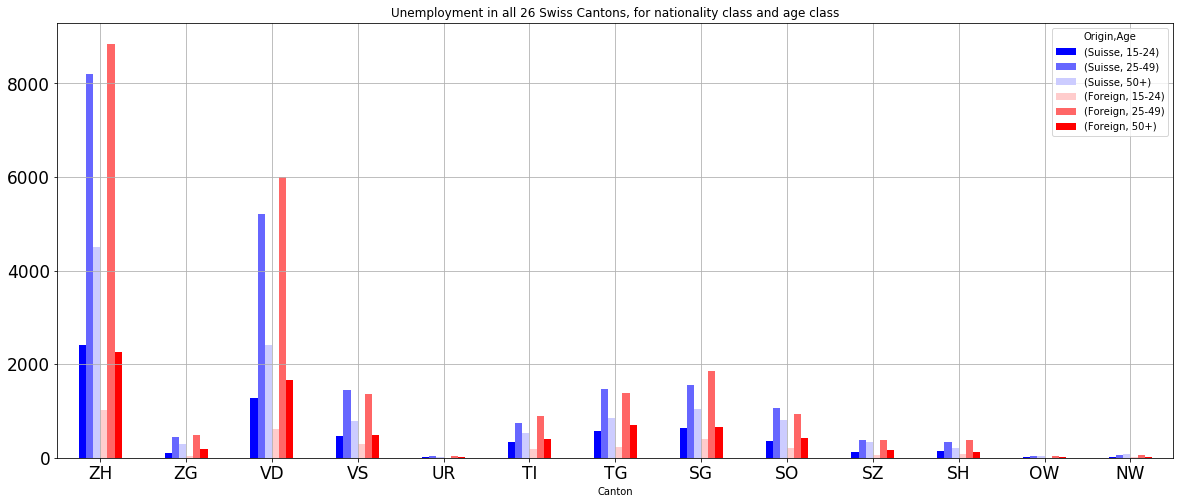

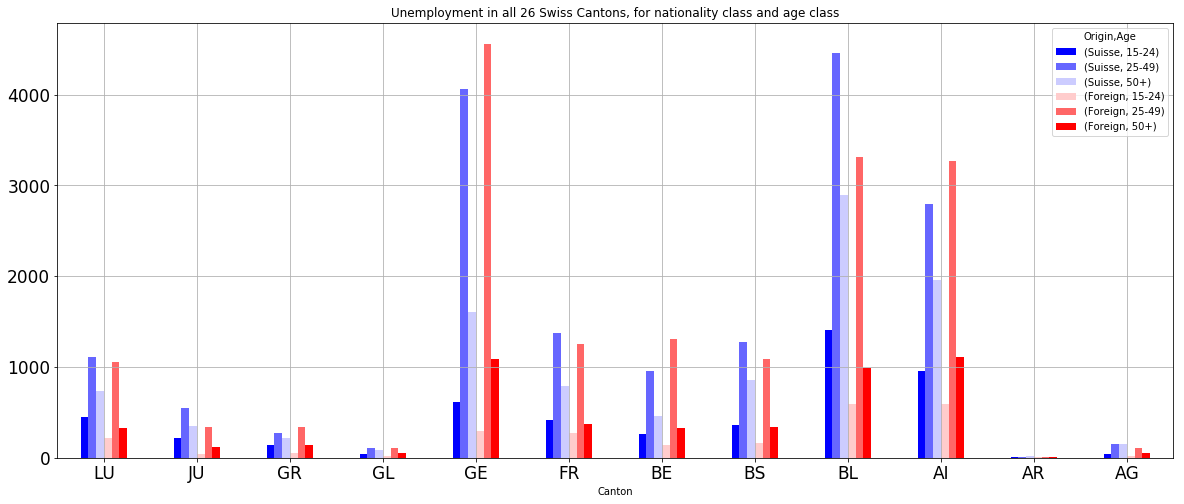

In [22]:
age_nationality_to_plot.iloc[0:13].plot(kind='bar',figsize=[20,8],fontsize=17, grid = True, \
                                        title='Unemployment in all 26 Swiss Cantons, for nationality class and age class',\
                                        colormap = 'bwr', legend = 'resident', rot = 0)
age_nationality_to_plot.iloc[14::].plot(kind='bar',figsize=[20,8],fontsize=17, grid = True,\
                                        title='Unemployment in all 26 Swiss Cantons, for nationality class and age class',\
                                        colormap = 'bwr', rot = 0)
plt.show()

The sheer numbers presented above don't say a lot. Still, we are able to identify the five main cantons with high industrial activity.    
Since we don't have access to the exact number of active people in each cathegory, we will make to different assumptions to approximate the true rates :
- First one, lets consider the active population in all class age is invariant with respect to the origin of the workers (foreign or swiss) in each canton.
- Second one, lets consider the active population in origin cathegory is invariant with respect to the age of the workers in each canton.

#### First assumption


In [23]:
nationality_rate.loc[:,'Ch1'] = nationality_rate['Ch1'].str.replace('\'','').astype(float)
nationality_rate['Active'] = round(nationality_rate['Ch1'].div(nationality_rate['Rate'])*100,0)

suisse_active = list(nationality_rate.loc[(nationality_rate['population'] == 'Suisses')].sort_values('Canton',ascending = False)['Active'])
foreign_active = list(nationality_rate.loc[(nationality_rate['population'] == 'Etrangers')].sort_values('Canton',ascending = False)['Active'])

In [24]:
assumption_1 = age_nationality_to_plot.copy()
assumption_1.columns = ['ch1','ch2','ch3','ch4','ch5','ch6']

assumption_1.loc[:,['ch1','ch2','ch3']] = assumption_1[['ch1','ch2','ch3']].div(suisse_active, axis =0)*3
assumption_1.loc[:,['ch4','ch5','ch6']] = assumption_1[['ch4','ch5','ch6']].div(foreign_active, axis =0)*3

assumption_1_to_plot = assumption_1.copy()
assumption_1_to_plot.columns = header
assumption_1_to_plot.columns.names = ['Origin', 'Age']

assumption_1_to_plot.head()

Origin    Suisse                       Foreign                    
Age        15-24     25-49       50+     15-24     25-49       50+
Canton                                                            
ZH      0.011934  0.040725  0.022340  0.013326  0.116135  0.029539
ZG      0.005680  0.027044  0.018276  0.006690  0.081099  0.029209
VD      0.015105  0.061446  0.028450  0.013386  0.128231  0.035383
VS      0.010750  0.033912  0.018338  0.019844  0.093482  0.033673
UR      0.001831  0.005898  0.004271  0.007132  0.034469  0.021395

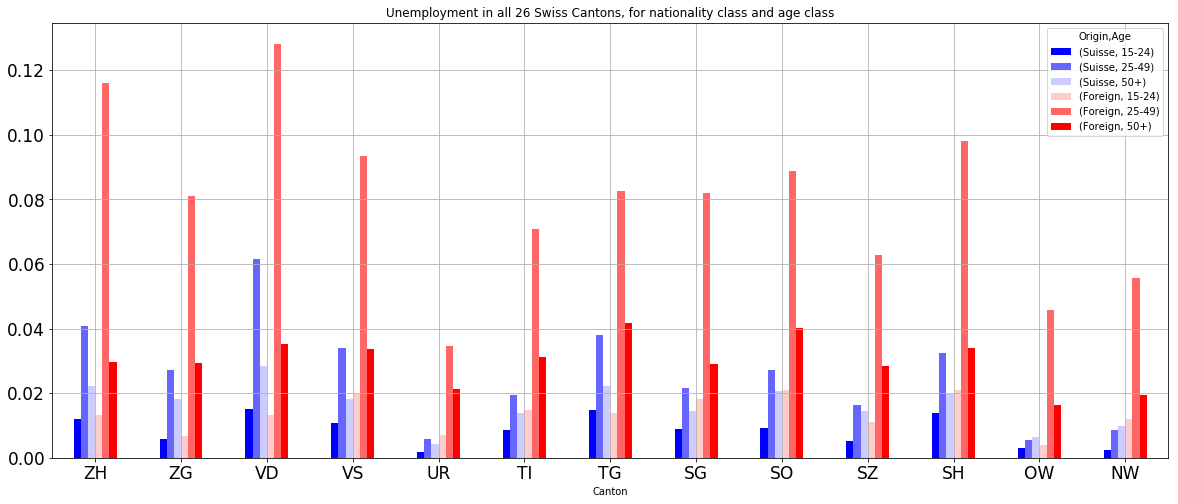

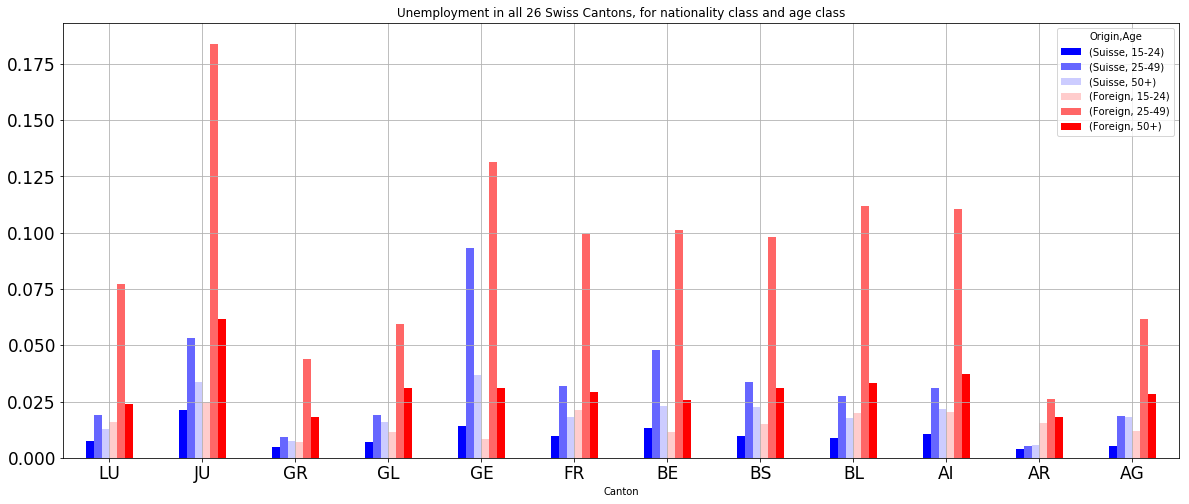

In [25]:
assumption_1_to_plot.iloc[0:13].plot(kind='bar',figsize=[20,8],fontsize=17, grid = True, \
                                        title='Unemployment in all 26 Swiss Cantons, for nationality class and age class',\
                                        colormap = 'bwr', rot = 0)
assumption_1_to_plot.iloc[14::].plot(kind='bar',figsize=[20,8],fontsize=17, grid = True,\
                                        title='Unemployment in all 26 Swiss Cantons, for nationality class and age class',\
                                        colormap = 'bwr', rot = 0)
plt.show()

From this plot, we can identify global unemployment tendency. We notice unemployment rates are higher for foreign residents, we believe the unemployment rates are higher for middle age population regardless of the origin of the resident. Of course this model is very limited because the range '25-49' might have the largest working population. 

#### Assumption 2

In [28]:
age_ratio = pd.read_csv('question3_data/age_ratio_2.txt', sep = ',', header = 1,names = ['age class','drop1','drop2','Rate','Ch1','drop3','drop4'])
age_ratio.drop(['drop1','drop2','drop3','drop4'], axis = 1, inplace = True)
age_ratio.head()

age_ratio.loc[:,'Ch1'] = age_ratio['Ch1'].str.replace('\'','').astype(float)
age_ratio['Active'] = round(age_ratio['Ch1'].div(age_ratio['Rate'])*100,0)

age_1_active = list(age_ratio.loc[(age_ratio['age class'] == 1)].sort_index(ascending = False)['Active'])
age_2_active = list(age_ratio.loc[(age_ratio['age class'] == 2)].sort_index(ascending = False)['Active'])
age_3_active = list(age_ratio.loc[(age_ratio['age class'] == 3)].sort_index(ascending = False)['Active'])

In [29]:
assumption_2 = age_nationality_to_plot.copy()
assumption_2.columns = ['ch1','ch2','ch3','ch4','ch5','ch6']

assumption_2.loc[:,['ch1','ch4']] = assumption_2[['ch1','ch4']].div(age_1_active, axis =0)*2
assumption_2.loc[:,['ch2','ch5']] = assumption_2[['ch2','ch5']].div(age_2_active, axis =0)*2
assumption_2.loc[:,['ch3','ch6']] = assumption_2[['ch3','ch6']].div(age_3_active, axis =0)*2

assumption_2_to_plot = assumption_2.copy()
assumption_2_to_plot.columns = header
assumption_2_to_plot.columns.names = ['Origin', 'Age']

assumption_2_to_plot.head()

Origin    Suisse                       Foreign                    
Age        15-24     25-49       50+     15-24     25-49       50+
Canton                                                            
ZH      0.052038  0.032726  0.038672  0.021962  0.035274  0.019328
ZG      0.024902  0.022486  0.028666  0.011098  0.025515  0.017335
VD      0.057770  0.042777  0.042710  0.028230  0.049223  0.029289
VS      0.040609  0.028960  0.030827  0.025391  0.027040  0.019173
UR      0.006000  0.005000  0.007539  0.004000  0.005000  0.006462

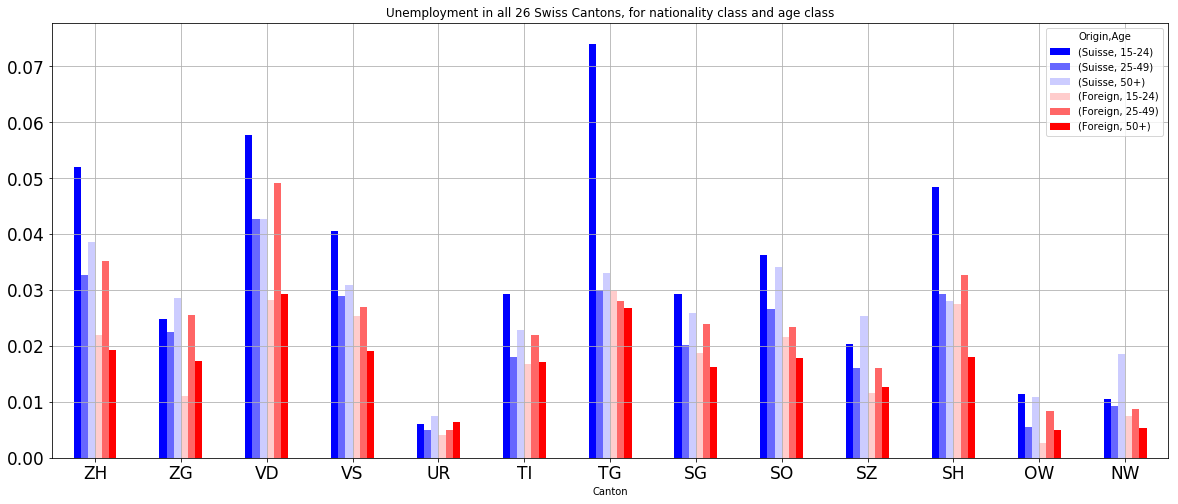

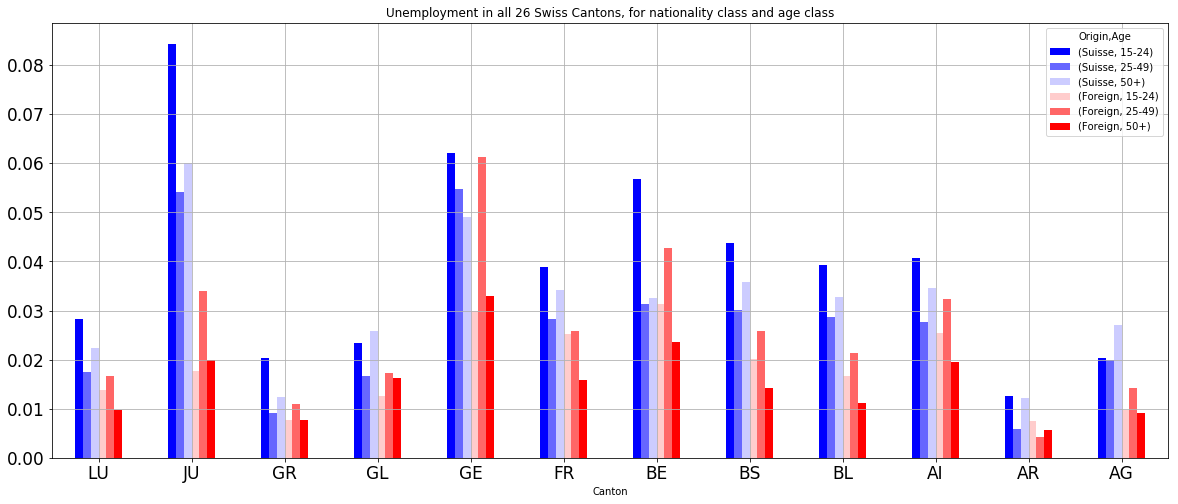

In [30]:
assumption_2_to_plot.iloc[0:13].plot(kind='bar',figsize=[20,8],fontsize=17, grid = True, \
                                        title='Unemployment in all 26 Swiss Cantons, for nationality class and age class',\
                                        colormap = 'bwr', rot = 0)
assumption_2_to_plot.iloc[14::].plot(kind='bar',figsize=[20,8],fontsize=17, grid = True,\
                                        title='Unemployment in all 26 Swiss Cantons, for nationality class and age class',\
                                        colormap = 'bwr', rot = 0)
plt.show()

From this plot, we can identify global unemployment tendency. Here we have considered the active population is equal for a given age class in both foreign and suisse cathegories.  
We notice unemployment rates are higher for age 15-24 for swiss residents and for age 25-49 for foreign residents. 
Of course this model is very limited because the range swiss residents might have the larger working population than foreign residents. 

# 4 Bonus

In [31]:
French = ['JU','GE','VD','FR','VS','NE','BE']
Deutch = ['ZH','LU','UR','SZ','OW','NW','GL','ZG','SO','BS','BL','SH','AR','AI','SG','AG','TG','GR']
Italian = ['TI']

rostigraben = pd.DataFrame()
rostigraben['Rates'] = foreign_suisse[['Suisse','Foreign']].mean(axis = 1)
rostigraben['Swiss Rates'] = foreign_suisse[['Suisse']]
rostigraben['Foreign Rates'] = foreign_suisse[['Foreign']]

rostigraben['Canton']= foreign_suisse['Abrev']
rostigraben.set_index('Canton', drop = False, inplace = True)

rostigraben.loc[French,['Rates','Swiss Rates','Foreign Rates']] = [rostigraben.loc[French,['Rates','Swiss Rates','Foreign Rates']].mean(axis = 0)]*len(French)
rostigraben.loc[Deutch,['Rates','Swiss Rates','Foreign Rates']] = [rostigraben.loc[Deutch,['Rates','Swiss Rates','Foreign Rates']].mean(axis = 0)]*len(Deutch)
rostigraben.loc[Italian,['Rates','Swiss Rates','Foreign Rates']] = [rostigraben.loc[Italian,['Rates','Swiss Rates','Foreign Rates']].mean(axis = 0)]*len(Italian)


In [32]:
m_rostigraben_total = folium.Map([47,8.5], tiles='cartodbpositron', min_zoom = 8, max_zoom  = 8)

m_rostigraben_total.choropleth(geo_data=canton_topojson, topojson = 'objects.cantons', data=rostigraben.loc[canton_order_map,:],
             columns=['Canton', 'Rates'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.9,
             legend_name='Unemployement ratios')

m_rostigraben_total.save('question3_data/rostigraben_total.html')

In [33]:
m_rostigraben_suisse = folium.Map([47,8.5], tiles='cartodbpositron', min_zoom = 8, max_zoom  = 8)

m_rostigraben_suisse.choropleth(geo_data=canton_topojson, topojson = 'objects.cantons', data=rostigraben.loc[canton_order_map,:],
             columns=['Canton', 'Swiss Rates'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.9,
             legend_name='Unemployement ratios')

m_rostigraben_suisse.save('question3_data/rostigraben_suisse.html')

In [34]:
m_rostigraben_foreign = folium.Map([47,8.5], tiles='cartodbpositron', min_zoom = 8, max_zoom  = 8)

m_rostigraben_foreign.choropleth(geo_data=canton_topojson, topojson = 'objects.cantons', data=rostigraben.loc[canton_order_map,:],
             columns=['Canton', 'Foreign Rates'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.9,
             legend_name='Unemployement ratios')

m_rostigraben_foreign.save('question3_data/rostigraben_foreign.html')

[Rostigraben Total Unemployement rates](question3_data/rostigraben_total.html)     
[Rostigraben Swiss Unemployement rates](question3_data/rostigraben_suisse.html)     
[Rostigraben Foreign Unemployement rates](question3_data/rostigraben_Foreign.html)     

We notice Italian and German speaking regions have very close unemployment rates in both Swiss and Foreign categories